In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 드라이브에 '2024.jpg'넣으세요.
# 코드 (2) 과정
        (3) 결과값

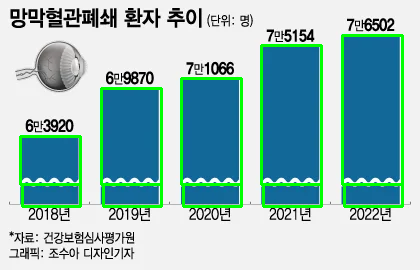

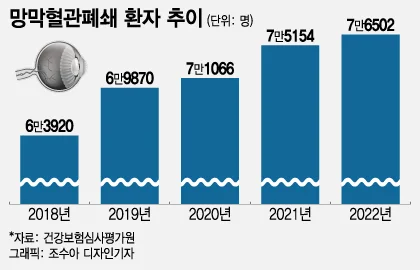

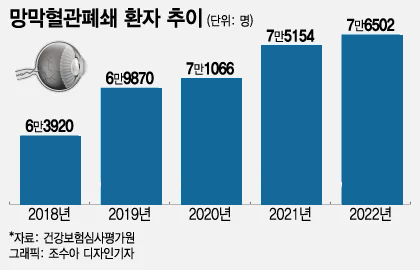

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
from collections import Counter

# 이미지 로드
image_path = '/content/drive/MyDrive/2024.jpg'
image = cv2.imread(image_path)

# 이미지를 그레이스케일로 변환
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# 이미지 이진화
_, binary = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV)

# 수평 선 검출
horizontal_kernel = np.ones((1, 10), np.uint8)
horizontal_lines = cv2.morphologyEx(binary, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)

# 수직 선 검출
vertical_kernel = np.ones((10, 1), np.uint8)
vertical_lines = cv2.morphologyEx(binary, cv2.MORPH_OPEN, vertical_kernel, iterations=2)

# 수평 및 수직 선 결합
combined_lines = cv2.bitwise_or(horizontal_lines, vertical_lines)

# 윤곽선 검출
contours, _ = cv2.findContours(combined_lines, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 막대의 너비와 높이 임계값 설정
threshold_width = 5
threshold_height = 20

# 각 윤곽선을 기준으로 막대의 경계를 추출하고 병합된 막대 생성
bars_by_x = {}  # x 좌표별로 막대를 그룹화하기 위한 딕셔너리
all_bars = []  # 모든 막대를 저장할 리스트
bar_colors = []  # 막대 색상을 저장할 리스트

for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    if w > threshold_width and h > threshold_height:
        center_x = x + w // 2  # 윤곽선의 중심 x 좌표
        if center_x not in bars_by_x:
            bars_by_x[center_x] = []
        bars_by_x[center_x].append((x, y, w, h))
        all_bars.append((x, y, w, h))

# 막대의 평균 너비를 계산
avg_width = np.mean([w for _, _, w, _ in all_bars])

# 평균 너비의 오차 범위 설정 (±10%)
error_margin = 0.1

# 특정 크기 이상의 윤곽선을 필터링
filtered_bars_by_x = {
    x: [bar for bar in bars if (1 - error_margin) * avg_width <= bar[2] <= (1 + error_margin) * avg_width]
    for x, bars in bars_by_x.items()
}

merged_bars = []

# 각 막대에 대해 병합된 직사각형 생성
for x in filtered_bars_by_x:
    bars = filtered_bars_by_x[x]
    if len(bars) > 1:
        # 막대가 두 개 이상으로 나뉘어져 있는 경우 병합
        min_x = min(bar[0] for bar in bars)
        min_y = min(bar[1] for bar in bars)
        max_x = max(bar[0] + bar[2] for bar in bars)
        max_y = max(bar[1] + bar[3] for bar in bars)
        width = max_x - min_x
        height = max_y - min_y
        # 두 세로선의 길이를 비교하여 더 긴 세로선을 기준으로 병합
        if bars[0][3] >= bars[1][3]:  # 첫 번째 막대의 세로선이 더 긴 경우
            final_x = bars[0][0]
        else:  # 두 번째 막대의 세로선이 더 긴 경우
            final_x = bars[1][0]
        merged_bars.append((final_x, min_y, width, height))
    elif len(bars) == 1:
        merged_bars.append(bars[0])

# x 좌표 정렬
merged_bars = sorted(merged_bars, key=lambda bar: bar[0])

# 병합된 막대를 기준으로 사각형 그리기
output_image = image.copy()
for x, y, w, h in merged_bars:
    cv2.rectangle(output_image, (x, y), (x + w, y + h), (0, 255, 0), 2)

# 결과 표시
cv2_imshow(output_image)

# 윤곽선을 기준으로 막대의 경계를 추출
bars = []  # 막대를 저장할 리스트
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    # 막대의 너비와 높이가 일정 크기 이상인 경우에만 막대로 간주
    if w > avg_width and h > threshold_height:
        # 세로형 막대의 경우 가로 길이가 일정하므로 각 막대의 중앙에 막대 하나의 가로 길이를 갖는 사각형을 그림
        center_x = x + w // 2
        adjusted_x = center_x - w // 2  # 중앙에 맞춘 x 좌표
        bars.append((adjusted_x, y, w, h))  # 막대 추가
        # 막대 색상 추출
        bar_roi = image[y:y+h, x:x+w]
        bar_roi_reshaped = bar_roi.reshape(-1, bar_roi.shape[-1])
        most_common_color = Counter(map(tuple, bar_roi_reshaped)).most_common(1)[0][0]
        bar_colors.append(most_common_color)

# 막대를 기준으로 병합
merged_bars = []  # 병합된 막대를 저장할 리스트
for x1, y1, w1, h1 in bars:
    merged = False
    for i, (x2, y2, w2, h2) in enumerate(merged_bars):
        # x축 위치가 일정 범위 내에 있으면 병합
        if abs(x1 - x2) < threshold_width:
            merged_x = min(x1, x2)
            merged_y = min(y1, y2)
            merged_w = max(x1 + w1, x2 + w2) - merged_x
            merged_h = max(y1 + h1, y2 + h2) - merged_y
            merged_bars[i] = (merged_x, merged_y, merged_w, merged_h)
            merged = True
            break
    if not merged:
        merged_bars.append((x1, y1, w1, h1))

# 중간 결과 표시
cv2_imshow(image)

# 병합된 막대를 기준으로 내부를 채우고 윤곽선 제거
output_image = image.copy()

for i, (x, y, w, h) in enumerate(merged_bars):
    # 저장된 색상으로 막대 내부를 채우기
    color = tuple(int(c) for c in bar_colors[i])  # 색상을 올바른 형식으로 변환
    cv2.rectangle(output_image, (x, y), (x + w, y + h - 2), color, -1)  # 높이 h를 줄여서 윤곽선이 보이지 않도록

# 윤곽선 제거된 결과 표시
cv2_imshow(output_image)


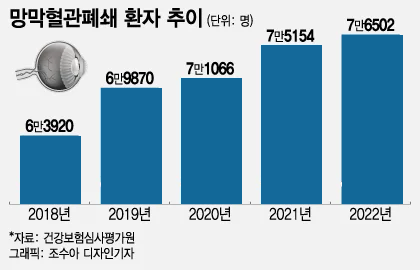

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
from collections import Counter

# 이미지 로드
image_path = '/content/drive/MyDrive/2024.jpg'
image = cv2.imread(image_path)

# 이미지를 그레이스케일로 변환
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# 이미지 이진화
_, binary = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV)

# 수평 선 검출
horizontal_kernel = np.ones((1, 10), np.uint8)
horizontal_lines = cv2.morphologyEx(binary, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)

# 수직 선 검출
vertical_kernel = np.ones((10, 1), np.uint8)
vertical_lines = cv2.morphologyEx(binary, cv2.MORPH_OPEN, vertical_kernel, iterations=2)

# 수평 및 수직 선 결합
combined_lines = cv2.bitwise_or(horizontal_lines, vertical_lines)

# 윤곽선 검출
contours, _ = cv2.findContours(combined_lines, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 막대의 너비와 높이 임계값 설정
threshold_width = 5
threshold_height = 20

# 각 윤곽선을 기준으로 막대의 경계를 추출하고 병합된 막대 생성
bars_by_x = {}  # x 좌표별로 막대를 그룹화하기 위한 딕셔너리
all_bars = []  # 모든 막대를 저장할 리스트
bar_colors = []  # 막대 색상을 저장할 리스트

for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    if w > threshold_width and h > threshold_height:
        center_x = x + w // 2  # 윤곽선의 중심 x 좌표
        if center_x not in bars_by_x:
            bars_by_x[center_x] = []
        bars_by_x[center_x].append((x, y, w, h))
        all_bars.append((x, y, w, h))

# 막대의 평균 너비를 계산
avg_width = np.mean([w for _, _, w, _ in all_bars])

# 평균 너비의 오차 범위 설정 (±10%)
error_margin = 0.1

# 특정 크기 이상의 윤곽선을 필터링
filtered_bars_by_x = {
    x: [bar for bar in bars if (1 - error_margin) * avg_width <= bar[2] <= (1 + error_margin) * avg_width]
    for x, bars in bars_by_x.items()
}

merged_bars = []

# 각 막대에 대해 병합된 직사각형 생성
for x in filtered_bars_by_x:
    bars = filtered_bars_by_x[x]
    if len(bars) > 1:
        # 막대가 두 개 이상으로 나뉘어져 있는 경우 병합
        min_x = min(bar[0] for bar in bars)
        min_y = min(bar[1] for bar in bars)
        max_x = max(bar[0] + bar[2] for bar in bars)
        max_y = max(bar[1] + bar[3] for bar in bars)
        width = max_x - min_x
        height = max_y - min_y
        merged_bars.append((min_x, min_y, width, height))
    elif len(bars) == 1:
        merged_bars.append(bars[0])

# x 좌표 정렬
merged_bars = sorted(merged_bars, key=lambda bar: bar[0])

# 윤곽선을 기준으로 막대의 경계를 추출
bars = []  # 막대를 저장할 리스트
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    # 막대의 너비와 높이가 일정 크기 이상인 경우에만 막대로 간주
    if w > avg_width and h > threshold_height:
        # 세로형 막대의 경우 가로 길이가 일정하므로 각 막대의 중앙에 막대 하나의 가로 길이를 갖는 사각형을 그림
        center_x = x + w // 2
        adjusted_x = center_x - w // 2  # 중앙에 맞춘 x 좌표
        bars.append((adjusted_x, y, w, h))  # 막대 추가
        # 막대 색상 추출
        bar_roi = image[y:y+h, x:x+w]
        bar_roi_reshaped = bar_roi.reshape(-1, bar_roi.shape[-1])
        most_common_color = Counter(map(tuple, bar_roi_reshaped)).most_common(1)[0][0]
        bar_colors.append(most_common_color)

# 막대를 기준으로 병합
merged_bars = []  # 병합된 막대를 저장할 리스트
for x1, y1, w1, h1 in bars:
    merged = False
    for i, (x2, y2, w2, h2) in enumerate(merged_bars):
        # x축 위치가 일정 범위 내에 있으면 병합
        if abs(x1 - x2) < threshold_width:
            merged_x = min(x1, x2)
            merged_y = min(y1, y2)
            merged_w = max(x1 + w1, x2 + w2) - merged_x
            merged_h = max(y1 + h1, y2 + h2) - merged_y
            merged_bars[i] = (merged_x, merged_y, merged_w, merged_h)
            merged = True
            break
    if not merged:
        merged_bars.append((x1, y1, w1, h1))

# 병합된 막대를 기준으로 내부를 채우고 윤곽선 제거
output_image = image.copy()

for i, (x, y, w, h) in enumerate(merged_bars):
    # 막대의 시작점을 위로 이동하지 않고, 높이를 줄여서 그리기
    h -= 3  # 높이를 원하는 만큼 줄이기
    # 저장된 색상으로 막대 내부를 채우기
    color = tuple(int(c) for c in bar_colors[i])  # 색상을 올바른 형식으로 변환
    cv2.rectangle(output_image, (x, y), (x + w, y + h), color, -1)

# 결과 표시
cv2_imshow(output_image)
